# DETERMINING THE DENSITY DISTRIBUTION IN A VIBRATING STRING

Based on:

*Valentine, A. P., & Trampert, J. (2016). The impact of approximations and arbitrary choices on geophysical images. Geophysical Journal International, 204(1), 59-73.*


To illustrate some of the points of the presentation a simple synthetic imaging problem is used: The determination of the density of a vibrating string. The string is assumed to have unit length and be under unit tension. We describe the displacement of the string by $y(x,t)$ with $x$ being the position on the string ($0\leq x \leq 1$). The density distribution is described by the function $\rho(x)$ and the string has a damping parameter of $\alpha=0.5$.

This behaviour can described by the wave equation 
$$\frac{\partial^{2} y}{\partial x^{2}}=\rho(x) \frac{\partial^{2} y}{\partial t^{2}}+\alpha \frac{\partial y}{\partial t}$$
subject to the boundary conditions $y(0,t) = y(1,t) = 0)$ and an initial configuration $y(x,0) = y_0(x)$. This means the string is fixed at both ends an exited in a manner described by $y_0$. The string is initally at rest meaning $\dot{y}(x,0) = 0$. The dot represents the time derivative.

In [1]:
# standard imports
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp, odeint, quad
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from numba import jit
import math

# % matplotlib inline
plt.rcParams["figure.figsize"] = (10,5)

# just being lazy
pi = np.pi

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## The Forward Problem

Bevor any inverse problem can be formulated it is necessary to first describe and construct the forward problem. We use a normal-mode approach to solve this problem. Any solution that satisfies the boundary conditions can be written in the follwing form
$$ y(x, t)=\sum_{n=1}^{\infty} a_{n}(t) \sin (n \pi x)$$.
The sinusoids naturally fullfill the boundary conditions. As an orthogonal set of basis functions they can be used to describe any displacement of the string. It is also necessary to define how the coefficients can be calculated for a given displacement function:
$$ a_{n}(t)=2 \int_{0}^{1} y_t(x) \sin (n \pi x) \mathrm{d} x $$
Here $y_t$ describes the displacement at a given time step.

In [2]:
# first of all we need to define functions to converte between normal mode coefficients and the funtion describing displacement 

# this function returns the displacement given a set of normal mode coefficients up to a certain order
@jit # using numba to make calculations faster (jit = just in time compilation)
def a2y(x, a_n):
    y = np.zeros(len(x))
    for n in range(1,len(a_n)+1):
        y += a_n[n-1] * np.sin(n * pi * x)
    return y

# the same as function a2y but takes the coefficients for many time steps for faster computation using numpy
def a2y_array(x, a_n_t, N):
    y_t = np.zeros([len(t), len(x)])
    sin_array = np.array( [np.sin(n * pi * x) for n in range(1, N+1)] ) 
    y_t = np.matmul(a_n_t, sin_array)
            
    return y_t

# calculate normal mode coefficients a_n from given displacement y
def y2a(x, y, N):
    a_n = np.zeros(N)
    def a_n_int(x, y, n):
        return y(x) * np.sin(n * pi * x)
    for n in range(1,N+1):
        a_n[n-1], _ = quad(a_n_int, 0, 1, args=(y,n), limit=1000)
        a_n[n-1] *= 2        
    return a_n

After defining the basic framework it is now necessary to define our environment. This includes the normal mode cut-off (we can't take an infinitly long series), a function describing the density distribution, one describing the initial displacement and the attenuation parameter.

In [3]:
# define everything initialy know

N = 30                        # normal mode expansion cut off
x = np.linspace(0,1,1000)     # array describing spatial discretisation
t = np.linspace(0,60,1000)    # array describing time discretisation

# parameters
alpha = 0.5                   # damping coefficient

# function describing initial position of string
def y_init_func(x):
    return np.exp(-8*(5*x-1)**2)
# normal mode expansion coefficients for initial condition
a_n_init = y2a(x, y_init_func, N)

# function describing density distriution in string
def rho_func(x):
    return 5 + 3 * x**2 + math.cos(5 * pi * x)
# same as rho_func but taking an array as input (math is faster than numpy for scalars)
def rho_func_array(x):
    return 5 + 3 * x**2 + np.cos(5 * pi * x)

Now we have defined our environment and can think about how we want to solve this problem. If we truncate the normal mode expansion it can be described as a system coupled ordinary differential equations (ODEs) which can be solved using existing python packages. But first lets describe the derivation of the ODE:

First of all we substitute the normal mode expansion into the wave equation. This results in the following equation
$$ a_{n}(t)= \frac{-1}{n^{2} \pi^{2}}\left[\alpha \frac{\mathrm{d} a_{n}}{\mathrm{~d} t}+2 \sum_{m} \frac{\mathrm{d}^{2} a_{m}}{\mathrm{~d} t^{2}}\right. \left.\times \int_{0}^{1} \rho(x) \sin (m \pi x) \sin (n \pi x) \mathrm{d} x\right] \label{eq1}\tag{1} $$
where we already introduced the cut off after N terms in the normal mode expansion. The orthogonality of the basis functions has been used to rearange the equation to this shape.  To make this equation more clear we can define two matrices based on this equation. First we can describe the coupling between the different modes by the following matrix
$$ M_{n m}=\int_{0}^{1} \rho(x) \sin (m \pi x) \sin (n \pi x) \mathrm{d} x .$$
For an homogenous string all off-diagonal components would be zero and there would be no coupling between modes. We can also define the matrix $\mathbf{K}$ for convenience as 
$$ K_{nm} = \frac{\delta_{nm}}{n^2\pi^2}.$$
The definition of the matrices is done in the following two cells:

In [4]:
def M_nm(N, rho_func):
    M = np.zeros((N, N))
    
    # define integrand 
    def m_int(x, rho_func, m, n):
        return rho_func(x) * math.sin(m*pi*x) * math.sin(n*pi*x)
    
    for n in range(1,N+1):
        for m in range(1,N+1):
            if m >= n:
                M[n-1,m-1], _ = quad(m_int, 0, 1, args=(rho_func, m, n), limit=1000)
            # take advantage of symmetry to cut computation time
            else: 
                M[n-1, m-1] = M[m-1, n-1]
    return M

def K_nm(N):
    K = np.zeros((N, N), dtype=np.double)
    
    for n in range(1,N+1):
        K[n-1, n-1] = 1/(n**2 * pi**2)
    
    return K

Using the matrices $\mathbf{M}$ and $\mathbf{K}$ it is now possible to define the system of coupled ODEs in a clear and concise way as
$$ \frac{\mathrm{d}}{\mathrm{d} t}\left(\begin{array}{l}
\mathbf{a} \\
\mathbf{\dot{a}}
\end{array}\right)=\left(\begin{array}{cc}
-\alpha \mathbf{K} & -2 \mathbf{K} \mathbf{M} \\
\mathbf{I} & 0
\end{array}\right)^{-1}\left(\begin{array}{l}
\mathbf{a} \\
\mathbf{\dot{a}}
\end{array}\right) .$$
This system is equivalent to equation (1). Using the initial condition of the initial displacement and no initial velocity this can be solved using existing ODE solvers. We do not need to specify the boundary conditions as these are fullfilled per definition by the sinusoids.

In [5]:
def solve_forward_problem(N, rho_func, a_n_init, x, t):
    # construct matrix A
    A = np.zeros([2*N, 2*N])
    A[:N, :N] = -alpha * K_nm(N)
    A[:N, N:] = -2 * np.matmul(K_nm(N), M_nm(N, rho_func))
    A[N:, :N] = np.identity((N))

    # and invert it as A^-1 is needed for ODE solver
    A_inv = np.linalg.inv(A)
    
    # set initial conditions
    iv = np.zeros(2*N)
    iv[:N] = a_n_init
    # other initial conditions are zero
    
    # define rhs and calculate solution of coupled ode
    def func_rhs(y, t, A_inv):
        '''y = a: contains both a and the derivative of a '''  
        return A_inv.dot(y)
    a_sol = odeint(func_rhs, iv, t, args=(A_inv,), )

    # calculate displacement from coefficients
    y = np.zeros([len(t), len(x)])
    for i in range(len(t)):
        y[i] = a2y(x, a_sol[i,:N])
        
    return y

After defining and setting up the forward problem we can now solve the system.

In [6]:
y_true = solve_forward_problem(N, rho_func, a_n_init, x, t)

The displacement of the string through time is shown in the next cell:

In [7]:
def plot_y_interactive(y, N_t=100, stepsize=1):
    def plotter(t=0):
        plt.figure(figsize=(20,5))
        plt.plot(x, y[t])
        plt.ylim((-1,1))
        plt.ylabel('Displacement')
        plt.xlabel('Position')
        return

    interact(plotter, t=(0,N_t,stepsize))
    plt.show()

plot_y_interactive(y_true, 100)

interactive(children=(IntSlider(value=0, description='t'), Output()), _dom_classes=('widget-interact',))

While this looks cool and provides some insight into the system it is not particulary useful for our inverse problem. More useful is placing 'stations' at certain points which then provide seismograms of the vibrations of the string. This is done in the following for a station at the position $x=0.8$.

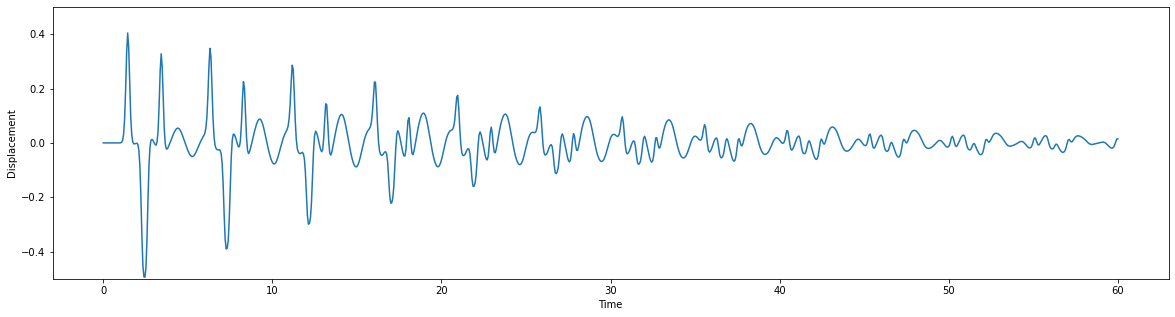

In [8]:
def plot_seismogram(y, position):
    plt.plot(t, y[:, int(position*len(x))])
    plt.ylim(-0.5, 0.5)
    plt.ylabel('Displacement')
    plt.xlabel('Time')

plt.figure(figsize=(20,5))
plot_seismogram(y_true, 0.8)

Now the forward problem is solved and we have everything we need to start constructing the inverse problem.

# Inverse Problem

We now have the observations and the forward problem necessary to set up an inverse problem. This requires us first of all to select a parametrization of the density distribution. For this we need a set of basis functions. With these we can define the density distribution, such that
$$ \tilde{\rho}(x) = \sum_{l=1}^L \rho_l \phi_l(x),$$
where $\rho_l$ are the model parameters and $\phi_l$ are the basis functions. The tilde emphazises that this is based on a finite expansion and can therefore not represent any distribution. The forward problem can easily be modified to depend on the model coefficients and basis functions. But to set up the inverse problem it is also necessary to compute the partial derivatives for each model parameter. This can readily be done in the same normal mode framework defining 
$$ \frac{\partial \tilde{y}}{\partial \rho_{\lambda}}=\sum_{n=1}^{N} \frac{\partial \tilde{a}_{n}}{\partial \rho_{\lambda}} \sin (n \pi x) $$ 
for each model parameter $\lambda$. This can then be substituted again into equation (1) which leads to the following system of coupled ODE's:
$$ \frac{\mathrm{d}}{\mathrm{d} t}\left(\begin{array}{c}
\tilde{\mathbf{a}} \\
\dot{\tilde{\mathbf{a}}} \\
\partial \tilde{\mathbf{a}} / \partial \rho_{\lambda} \\
\partial \dot{\tilde{\mathbf{a}}} / \partial \rho_{\lambda}
\end{array}\right)=\left(\begin{array}{cccc}
-\alpha \mathbf{K} & -2 \mathbf{K} \tilde{\mathbf{M}} & \mathbf{0} & \mathbf{0} \\
\mathbf{I} & \mathbf{0} & \mathbf{0} & \mathbf{0} \\
\mathbf{0} & -2 \mathbf{K} \boldsymbol{\Psi}^{(\lambda)} & -\alpha \mathbf{K} & -2 \mathbf{K} \mathbf{\tilde{M}} \\
\mathbf{0} & \mathbf{0} & \mathbf{I} & \mathbf{0}
\end{array}\right)^{-1} \times  \left(\begin{array}{c}
\tilde{\mathbf{a}} \\
\dot{\tilde{\mathbf{a}}} \\
\partial \tilde{\mathbf{a}} / \partial \rho_{\lambda} \\
\partial \dot{\tilde{\mathbf{a}}} / \partial \rho_{\lambda}
\end{array}\right)$$

Here the matrix $\mathbf{K}$ stays the same but $\mathbf{M}$ must be modified to account for the density parametrization. To define $\mathbf{\tilde{M}}$ we first need to define the matrix $\mathbf{\Psi}^{(\lambda)}$ with the elements
$$ \Psi_{m n}^{(\lambda)}=\int_{0}^{1} \psi_{\lambda}(x) \sin (m \pi x) \sin (n \pi x) \mathrm{d} x $$ 
and can then define that $\mathbf{\tilde{M}} = \sum_l \rho_l \mathbf{\Psi}^{(l)}$.

In this example we use piecwise basis functions which make analysis easier. But it has to be noted that global basis function would be better suited for a normal mode approach.

As an initial guess for the density we assume a homogenous distribution. We assume that we know the total mass of the string which we can use to calculate the average density.

In [9]:
# define parametrization of string density
L = 30          # number of basis functions used to describe density of string

def piecewise_basisfunc(x, k, K):
    if (k-1)/K <= x and x < k/K:
        return 1.0
    else:
        return 0.0
    
# initial guess for the density distribution defined by coefficients of the piecewise basis functions
mean_density = 6 
rho_i_init = np.ones(L) * mean_density

In [10]:
# define new matrix components needed for inversion

# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! piecewise basis function hard-coded to avoid integration problems !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

def Psi_nm_lam(N, lam, L):
    Psi = np.zeros([N, N])
    
    @jit
    def psi_int(x, m, n):
        return math.sin(m*pi*x) * math.sin(n*pi*x)
    
    for n in range(1,N+1):
        for m in range(1,N+1):
            if m >= n:
                int_min = (lam-1)/L 
                int_max = lam/L
                Psi[n-1,m-1], _ = quad(psi_int, int_min, int_max, args=(m, n,), limit=1000)
            # take advantage of symmetry to cut computation time
            else: 
                Psi[n-1,m-1] = Psi[m-1,n-1]
    return Psi

def M_tilde_mn(N, rho_i, L, Psi_nm_lam):
    M = np.zeros([N, N])
    
    for lam in range(1,L+1):
        M += rho_i[lam-1] * Psi_nm_lam(N, lam, L)
        print("\r" + str(lam), end="")
    print()
    return M

We now have everything we need to set up the inverse problem and solve it. The initial and boundary conditions stay the same with the addition, that the derivatives of the model parameters $\mathbf{\tilde{a}}$ and $\mathbf{\dot{\tilde{a}}}$ are zero.

In [11]:
def inversion_iteration(rho_i_init, y_true, N, L, K_nm, M_tilde_mn_fwd, M_tilde_mn_inv, Psi_nm_lam_fwd, Psi_nm_lam_inv, sta=[0.8], eps = 0.1, show_A_tilde=False):
    
    # set up submatrices to avoid multiple computations
    K_mat = K_nm(N)
    print('Setting up KM_fwd ...')
    KM_mat_fwd = np.matmul(K_mat, M_tilde_mn_fwd(N, rho_i_init, L, Psi_nm_lam_fwd))
    print('Setting up KM_inv ...')
    KM_mat_inv = np.matmul(K_mat, M_tilde_mn_inv(N, rho_i_init, L, Psi_nm_lam_inv))
    
    # KPHI needs to be computed for each spatial discretisation individualy
    print('Setting up K Phi for each lambda ...')
    KPHI_mat_lam = [] 
    for lam in range(L):
        KPHI_mat_lam.append(np.matmul(K_nm(N), Psi_nm_lam_inv(N, lam, L)))
        print("\r" + str(lam+1), end="")
    print()
    
    # calculate and solve forward problem for each model parameter 

    # extended initial value vector containing the model derivatives as well
    iv_tilde = np.zeros(4*N)
    iv_tilde[0:N] = y2a(x, y_init_func, N)

    # construc the parts of the matrix A_tilde not changing
    A_tilde_lam = np.zeros([4*N, 4*N])
    A_tilde_lam[  0:N  ,   0:N  ] = -alpha * K_mat[:,:]
    A_tilde_lam[  0:N  ,   N:2*N] = -2 * KM_mat_fwd[:,:]
    A_tilde_lam[  N:2*N,   0:N  ] = np.identity((N))
    A_tilde_lam[2*N:3*N, 2*N:3*N] = -alpha * K_mat[:,:]
    A_tilde_lam[2*N:3*N, 3*N:4*N] = -2 * KM_mat_inv[:,:]
    A_tilde_lam[3*N:4*N, 2*N:3*N] = np.identity((N))

    # collect the solutions in a list (while not necessary this allows to do the inversion step by step)
    a_sol_tilde = []
    
    for lam in range(L):    
        print("\r" + " Constructing A_tilde and calculating solution for lamda = {}".format(lam+1), end="")
        A_tilde_lam[2*N:3*N,   N:2*N] = -2 * KPHI_mat_lam[lam][:,:]
        A_tilde_lam_inv = np.linalg.inv(A_tilde_lam)
        
        def func_rhs_tilde(y, t, A_tilde_inv):
            '''y = a: contains both a and the derivative of a '''  
            return A_tilde_inv.dot(y)
        a_sol_lam_tilde = odeint(func_rhs_tilde, iv_tilde, t, args=(A_tilde_lam_inv,))

        a_sol_tilde.append(a_sol_lam_tilde)
    print()
    
    if show_A_tilde:
        plt.spy(A_tilde_lam)
        plt.show()
    
    # I doesent matter if only the last a coefficients are returened because the forward problem does not change for different lambdas
    a_n = a_sol_tilde[-1][:,:N]
    y_tilde = np.zeros([len(t), len(x)])
    for t_i in range(len(t)):
        y_tilde[t_i] = a2y(x, a_sol_tilde[-1][t_i,:N])

    print('Start constructing model dependence matrix')
    S_mi = np.zeros([len(sta), L, len(t)]) 
    for lam in range(L):
        dy_drho_tilde = a2y_array(x, a_sol_tilde[lam][:, 2*N:3*N], N)
        
        for i, sta_i in enumerate(sta):
            S_mi[i, lam] = dy_drho_tilde[:, int(sta_i*len(x))]
    
    new_rho_i = rho_i_init
    for i, sta_i in enumerate(sta):
        S_mi_inv = np.matmul(np.linalg.inv(np.matmul(S_mi[i].transpose(), S_mi[i]) + eps*np.identity(len(t))), S_mi[i].transpose())

        delta_y = y_true[:, int(sta_i*len(x))]-y_tilde[:, int(sta_i*len(x))]
        new_rho_i = new_rho_i + 1/len(sta) * np.matmul(S_mi_inv.transpose(), delta_y)

    # calculate misfit to real solution
    def cal_misfit(d, s):
        return np.sqrt( np.matmul((d-s).transpose(), (d-s)) / np.matmul(d.transpose(), d) )

    misfit = cal_misfit(y_true[:, 800], y_tilde[:, 800])
    
    return misfit, new_rho_i, y_tilde, S_mi

After the the function for one iteration is set up we can now run the first iteration. For better visualization the matrix describing the syste is plotted as well. For computational reasons the normal mode expansion had to be cut off at a fairly low value, this resulted in less than ideal convergence properties. To counteract this a number of stations has been added which all contribute to the step in model space.

Setting up KM_fwd ...
30
Setting up KM_inv ...
30
Setting up K Phi for each lambda ...
30
 Constructing A_tilde and calculating solution for lamda = 30


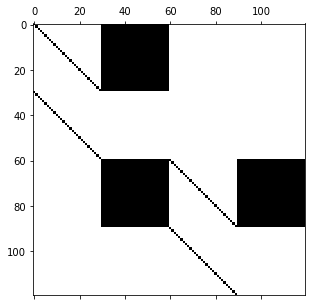

Start constructing model dependence matrix


In [12]:
misfit_exact, new_rho_i_exact, y_tilde_exact, S_mi_exact  = inversion_iteration(rho_i_init, y_true, N, L, K_nm, M_tilde_mn, M_tilde_mn, Psi_nm_lam, Psi_nm_lam, sta=[0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8], show_A_tilde=True)

As the forward problem is solved for as well we can look how the string behaves for the initial density distribution as described by the inital coefficients and basis functions.

In [13]:
plot_y_interactive(y_tilde_exact)

interactive(children=(IntSlider(value=0, description='t'), Output()), _dom_classes=('widget-interact',))

And we can also visuallize how the seismogram would look now for station $x=0.8$.

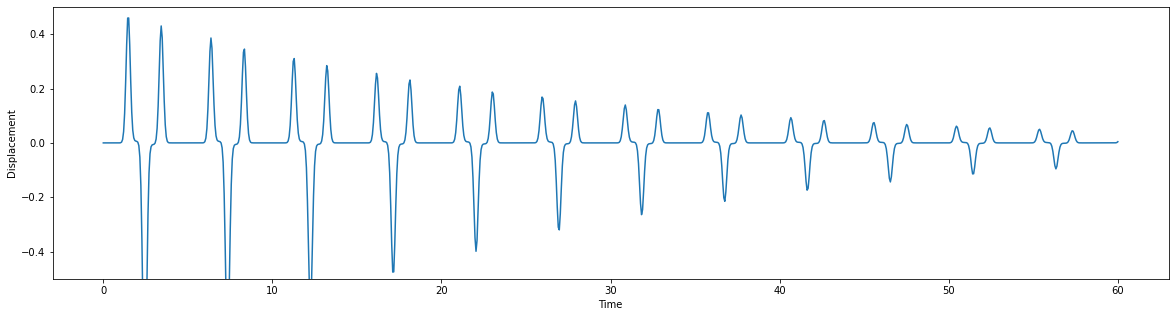

In [14]:
plt.figure(figsize=(20,5))
plot_seismogram(y_tilde_exact, 0.8)
y_init_exact = y_tilde_exact

The effect of a homogenous density distribution can be seen very well. Instead of scattering the two peaks stay the same and oscillate between the ends of the string while attenuating slowly. 

## Construction of the inverse operator

To define the inverse operator we first need to remember how the forward operator is defined. It is defined as 
$$\mathcal{S}_{\mathrm{m}_{\mathrm{i}}}(\mathbf{x})=\mathbf{A} \mathbf{x} $$ with $A_{ij} = \partial s_{i} /\partial m_{j} |_{\mathbf{m}=\mathbf{m}_{i}}$. From this we can then define the inverse operator by using least square minimization as
$$ \mathcal{S}_{\mathrm{m_i}}^{-g}(\mathbf{x})=\left(\mathbf{A}^{\mathrm{T}} \mathbf{A}+\mathbf{D}\right)^{-1} \mathbf{A}^{\mathrm{T}} \mathbf{x} $$ where the Tikhonov regularization $\mathbf{D} = \epsilon \mathbf{I}$ with $\epsilon=0.1$ has been used for $\mathbf{D}$. $\mathbf{A}$ can be directly calculated using the output of the solved system of coupled ODEs transformed from coefficients into displacement.

The model dependence matrix has already been calculated while defining the inversion step function. We can now have a look at it to maybe understand it better.

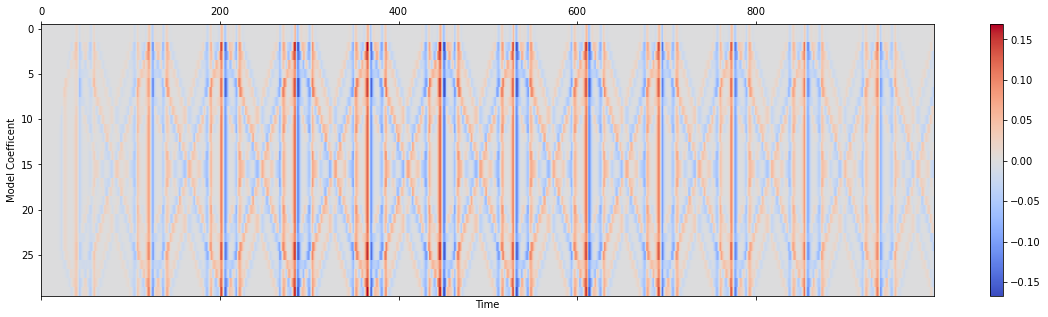

In [15]:
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(111)
col = ax.matshow(S_mi_exact[6], aspect='auto', cmap='coolwarm')
ax.set_ylabel('Model Coefficent')
ax.set_xlabel('Time')
fig.colorbar(col)
plt.show()

The density has also been updated in the 'inversion_iteration' function and we can have a look at the improved model.

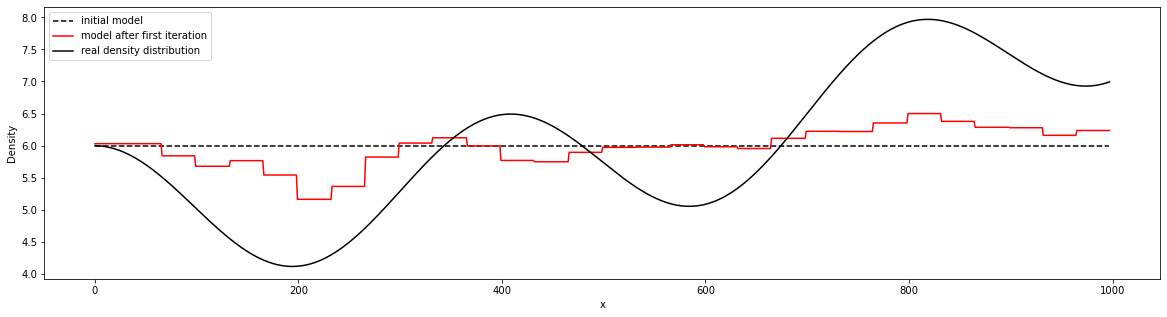

In [16]:
rho_real = rho_func_array(x)
rho_0 = np.zeros([len(x)])
rho_1 = np.zeros([len(x)])

for l in range(1,L+1):
    for i, x_i in enumerate(x):
        rho_0[i] += rho_i_init[l-1] * piecewise_basisfunc(x_i, l, L)
        rho_1[i] += new_rho_i_exact[l-1] * piecewise_basisfunc(x_i, l, L)
        
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(111)
ax.plot(rho_0[1:-1], 'k--', label='initial model')
ax.plot(rho_1[1:-1], 'r', label='model after first iteration')
ax.plot(rho_real[1:-1], 'k', label='real density distribution')
ax.set_ylabel('Density')
ax.set_xlabel('x')
plt.legend()
plt.show()

It can be see that the density model is far from perfect but already shows signs of converging to the real distribution. It is also intresting to keep track of the misfit to see how much each iteration changes the model. The misfit is simply defined as the sum of squares of the differences between the seismograms. 

In [17]:
misfit_list_exact = []
misfit_list_exact.append(misfit_exact)

Now we go on and do some more iteration steps and see how the model changes.

In [18]:
# starting at two because we already did one iteration
for i in range(2,9):
    print('============== Doing iteration: {} =============='.format(i))
    misfit_exact, new_rho_i_exact, y_tilde_exact, S_mi_exact  = inversion_iteration(new_rho_i_exact, y_true, N, L, K_nm, M_tilde_mn, M_tilde_mn, Psi_nm_lam, Psi_nm_lam, sta=[0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8])
    misfit_list_exact.append(misfit_exact)

============== Doing iteration: 2 ==============
Setting up KM_fwd ...
30
Setting up KM_inv ...
30
Setting up K Phi for each lambda ...
30
 Constructing A_tilde and calculating solution for lamda = 30
Start constructing model dependence matrix
============== Doing iteration: 3 ==============
Setting up KM_fwd ...
30
Setting up KM_inv ...
30
Setting up K Phi for each lambda ...
30
 Constructing A_tilde and calculating solution for lamda = 30
Start constructing model dependence matrix
============== Doing iteration: 4 ==============
Setting up KM_fwd ...
30
Setting up KM_inv ...
30
Setting up K Phi for each lambda ...
30
 Constructing A_tilde and calculating solution for lamda = 30
Start constructing model dependence matrix
============== Doing iteration: 5 ==============
Setting up KM_fwd ...
30
Setting up KM_inv ...
30
Setting up K Phi for each lambda ...
30
 Constructing A_tilde and calculating solution for lamda = 30
Start constructing model dependence matrix
============== Doing ite

After doing a few iterations we can now have a look at the 'final' density distribution.

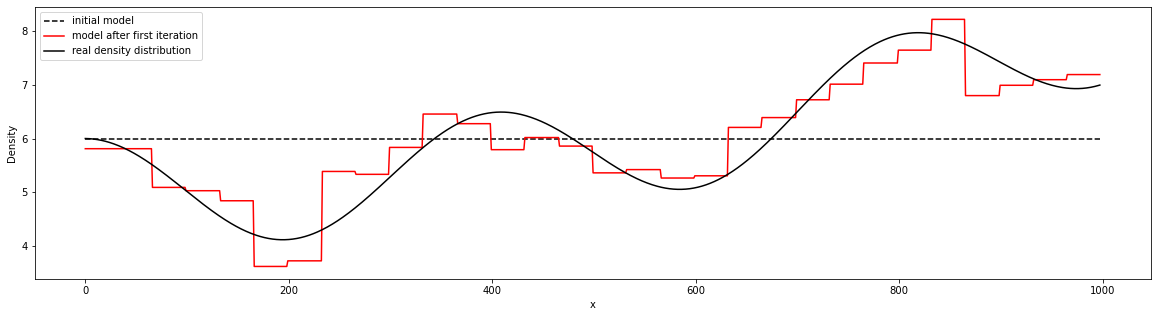

In [19]:
rho_real = rho_func_array(x)
rho_init_exact = np.zeros([len(x)])
rho_final_exact = np.zeros([len(x)])

for l in range(1,L+1):
    for i, x_i in enumerate(x):
        rho_init_exact[i] += rho_i_init[l-1] * piecewise_basisfunc(x_i, l, L)
        rho_final_exact[i] += new_rho_i_exact[l-1] * piecewise_basisfunc(x_i, l, L)
        
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(111)
ax.plot(rho_init_exact[1:-1], 'k--', label='initial model')
ax.plot(rho_final_exact[1:-1], 'r', label='model after first iteration')
ax.plot(rho_real[1:-1], 'k', label='real density distribution')
ax.set_ylabel('Density')
ax.set_xlabel('x')
plt.legend()
plt.show()

We can see that the model converged very well. Most of the differences can be distributed to the quite coarse parametrization and it also has to be noted that the normal mode cut off is fairly low to speed up the computations.

We can now have a look how the misfit changed and if we have already converged sufficiently.

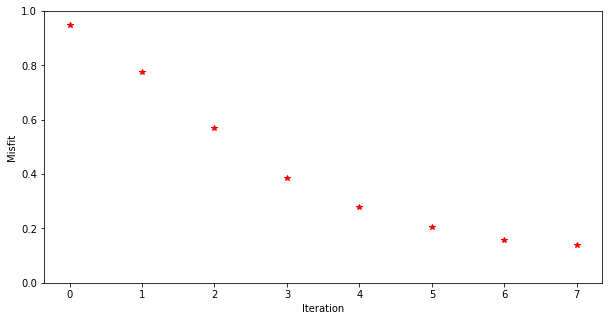

In [20]:
plt.figure(figsize=(10,5))
plt.plot(misfit_list_exact, 'r*')
plt.ylabel('Misfit')
plt.xlabel('Iteration')
plt.ylim(0,1)
plt.show()

Finally we can compare the true displacment to the one for the initial and final density models.

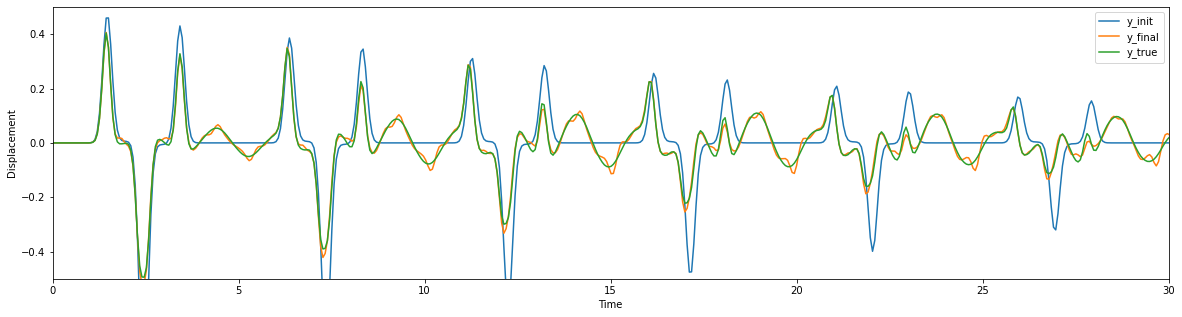

In [21]:
plt.figure(figsize=(20,5))
plot_seismogram(y_init_exact, 0.8)
plot_seismogram(y_tilde_exact, 0.8)
plot_seismogram(y_true, 0.8)
plt.xlim(0, 30)
plt.legend(['y_init', 'y_final', 'y_true'])
plt.show()

## An Approximate Theory

Till now we have only looked at the fully accurate forward and inverse problem. Now we can start introducing approximations and see how good an approximate theory can resolve the density distribution. To start with this it is instructive to have a look at the matrix $\mathbf{M}$.

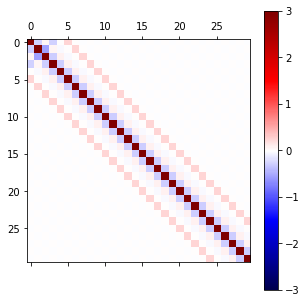

In [22]:
M = M_nm(N, rho_func)

plt.matshow(M, cmap='seismic', vmin=-3, vmax=3)
plt.colorbar()
plt.show()

We can clearly see the diagonal dominanz of the matrix $\mathbf M$. This allows us to introduce an approximation by neglecting the off-diagonal elements. This is similar to the use of a 'self-coupling' approximation used in global seismology. This means that there is no energy exchange between different modes due to the density heterogeity anymore. It is straightforward to derive the approximated ODE system.

In [23]:
# redefine Psi and M_tilde

def Psi_nm_lam_approx(N, lam, L):
    Psi = np.zeros([N, N])
    
    @jit
    def psi_int(x, n):
        return math.sin(n*pi*x) * math.sin(n*pi*x)
    
    for n in range(1,N+1):
        int_min = (lam-1)/L 
        int_max = lam/L
        Psi[n-1,n-1], _ = quad(psi_int, int_min, int_max, args=(n,), limit=1000)
    return Psi

def M_tilde_mn_approx(N, rho_i, L, Psi_nm_lam_approx):
    M = np.zeros([N, N])
    
    for lam in range(1,L+1):
        M += rho_i[lam-1] * Psi_nm_lam_approx(N, lam, L)
        print("\r" + str(lam), end="")
    print()
    return M

In [24]:
new_rho_i_approx = rho_i_init
misfit_list_approx = []

for i in range(1,9):
    print('============== Doing iteration: {} =============='.format(i))
    misfit_approx, new_rho_i_approx, y_tilde_approx, S_mi_approx  = inversion_iteration(new_rho_i_approx, y_true, N, L, K_nm,
                                                                                        M_tilde_mn_approx, M_tilde_mn_approx, Psi_nm_lam_approx, Psi_nm_lam_approx, sta=[0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8], show_A_tilde=False)
    misfit_list_approx.append(misfit_approx)

============== Doing iteration: 1 ==============
Setting up KM_fwd ...
30
Setting up KM_inv ...
30
Setting up K Phi for each lambda ...
30
 Constructing A_tilde and calculating solution for lamda = 30
Start constructing model dependence matrix
============== Doing iteration: 2 ==============
Setting up KM_fwd ...
30
Setting up KM_inv ...
30
Setting up K Phi for each lambda ...
30
 Constructing A_tilde and calculating solution for lamda = 30
Start constructing model dependence matrix
============== Doing iteration: 3 ==============
Setting up KM_fwd ...
30
Setting up KM_inv ...
30
Setting up K Phi for each lambda ...
30
 Constructing A_tilde and calculating solution for lamda = 30
Start constructing model dependence matrix
============== Doing iteration: 4 ==============
Setting up KM_fwd ...
30
Setting up KM_inv ...
30
Setting up K Phi for each lambda ...
30
 Constructing A_tilde and calculating solution for lamda = 30
Start constructing model dependence matrix
============== Doing ite

After calculating the final density model we can now compare how it performs.

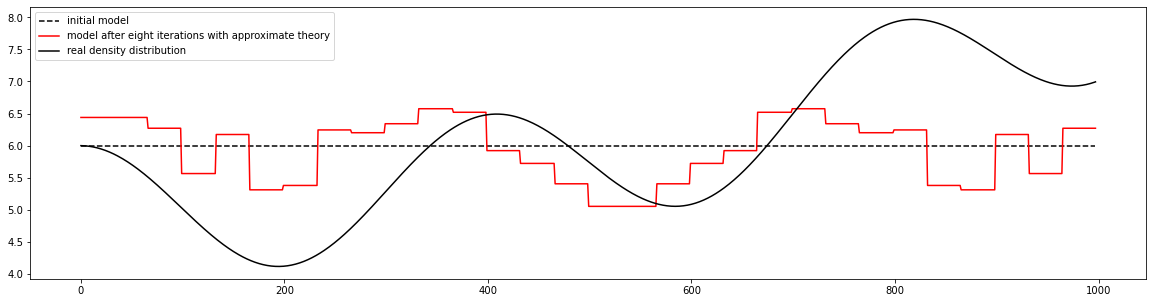

In [25]:
rho_real = rho_func_array(x)
rho_0 = np.zeros([len(x)])
rho_final_approx = np.zeros([len(x)])

for l in range(1,L+1):
    for i, x_i in enumerate(x):
        rho_0[i] += rho_i_init[l-1] * piecewise_basisfunc(x_i, l, L)
        rho_final_approx[i] += new_rho_i_approx[l-1] * piecewise_basisfunc(x_i, l, L)
        
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(111)
ax.plot(rho_0[1:-1], 'k--', label='initial model')
ax.plot(rho_final_approx[1:-1], 'r', label='model after eight iterations with approximate theory')
ax.plot(rho_real[1:-1], 'k', label='real density distribution')
plt.legend()
plt.show()

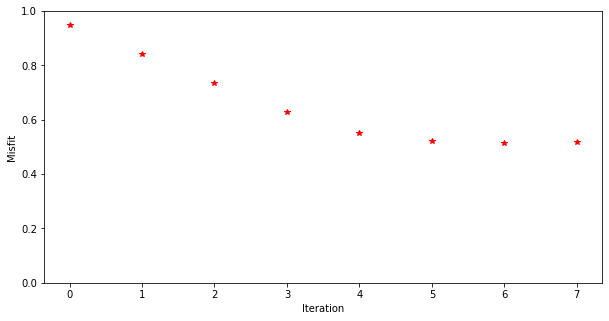

In [26]:
plt.figure(figsize=(10,5))
plt.plot(misfit_list_approx, 'r*')
plt.ylabel('Misfit')
plt.xlabel('Iteration')
plt.ylim(0,1)
plt.show()

The misfit and the final density model perform siginficantly worse than the exact inversion. But the significant decrease in misfit shows that the data can be fit acceptable while having a completly different density model.

From symmetry considerations of the matrices it is possible to derive that the inversion should theoretically only have sensitive to the symmetric part of the density distibution. To see if this holds we can decompose the true density structure into an even and an odd part.

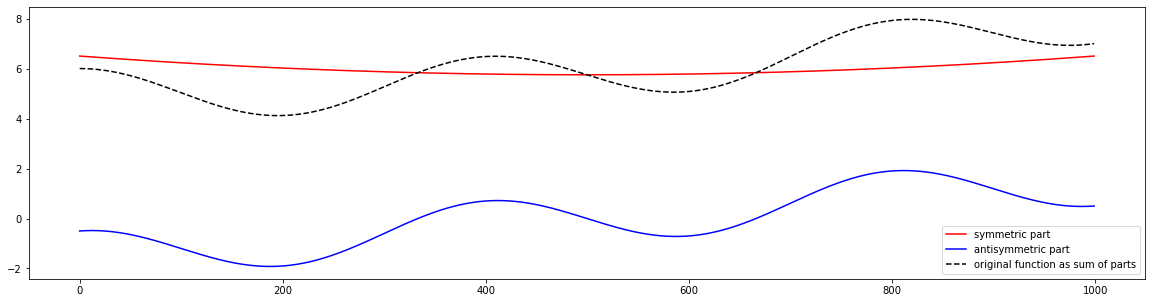

In [27]:
rho_sym = (rho_func_array(x) + rho_func_array( 2*0.5-x )) / 2 
rho_anti = (rho_func_array(x) - rho_func_array( 2*0.5-x )) / 2 

fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(111)
ax.plot(rho_sym, 'r', label='symmetric part')
ax.plot(rho_anti, 'b', label='antisymmetric part')
ax.plot(rho_sym + rho_anti, 'k--', label='original function as sum of parts')
plt.legend()
plt.show()

If we compare the symmetric part to the final density distribution, they do not look very similar.The only similarity is the range of values for the density. Any interpretation using this approximated framework is substantially mislead. 

## Hybrid Inversion

After testing the fully approximated case we now want to compare it to the hybrid case. This means that we will calulate the forward problem exact but use the approximated self-coupling theory for inversion.

In [28]:
new_rho_i_hybrid = rho_i_init
misfit_list_hybrid = []

for i in range(1,9):
    print('============== Doing iteration: {} =============='.format(i))
    misfit_hybrid, new_rho_i_hybrid, y_tilde_hybrid, S_mi_hybrid  = inversion_iteration(new_rho_i_hybrid, y_true, N, L, K_nm,
                                                                                        M_tilde_mn, M_tilde_mn_approx,Psi_nm_lam, Psi_nm_lam_approx, sta=[0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8], show_A_tilde=False)
    misfit_list_hybrid.append(misfit_hybrid)

============== Doing iteration: 1 ==============
Setting up KM_fwd ...
30
Setting up KM_inv ...
30
Setting up K Phi for each lambda ...
30
 Constructing A_tilde and calculating solution for lamda = 30
Start constructing model dependence matrix
============== Doing iteration: 2 ==============
Setting up KM_fwd ...
30
Setting up KM_inv ...
30
Setting up K Phi for each lambda ...
30
 Constructing A_tilde and calculating solution for lamda = 30
Start constructing model dependence matrix
============== Doing iteration: 3 ==============
Setting up KM_fwd ...
30
Setting up KM_inv ...
30
Setting up K Phi for each lambda ...
30
 Constructing A_tilde and calculating solution for lamda = 30
Start constructing model dependence matrix
============== Doing iteration: 4 ==============
Setting up KM_fwd ...
30
Setting up KM_inv ...
30
Setting up K Phi for each lambda ...
30
 Constructing A_tilde and calculating solution for lamda = 30
Start constructing model dependence matrix
============== Doing ite

[0.9475116500857212, 0.8338921052208044, 0.7152961611783183, 0.6028125281538023, 0.5226005390859553, 0.48947304955246296, 0.48114103973812, 0.4812626081922042]


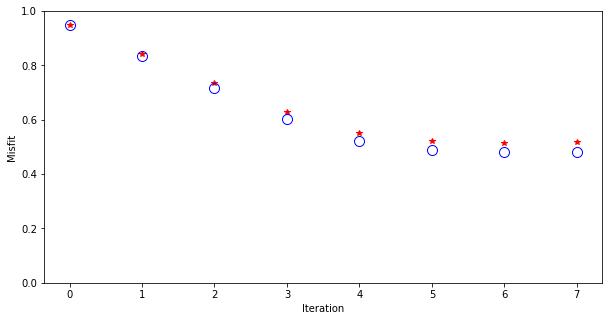

In [29]:
plt.figure(figsize=(10,5))
plt.plot(misfit_list_approx, 'r*')
plt.plot(misfit_list_hybrid, 'bo', markersize=10, fillstyle='none')
plt.ylabel('Misfit')
plt.xlabel('Iteration')
plt.ylim(0,1)
plt.show()

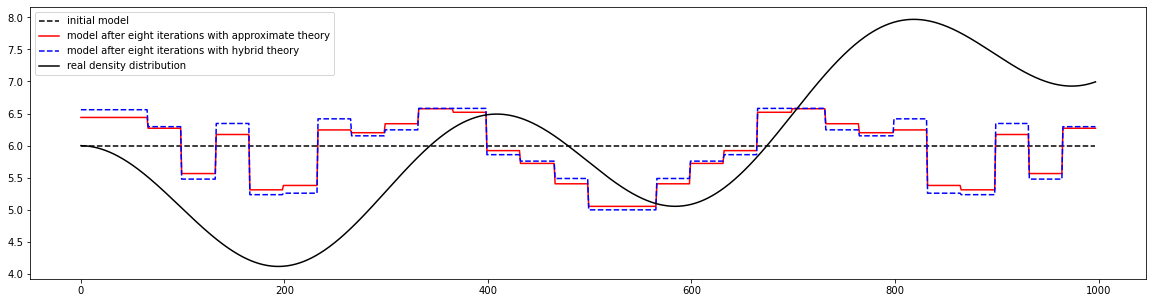

In [30]:
rho_final_hybrid = np.zeros([len(x)])

for l in range(1,L+1):
    for i, x_i in enumerate(x):
        rho_final_hybrid[i] += new_rho_i_hybrid[l-1] * piecewise_basisfunc(x_i, l, L)
        
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(111)
ax.plot(rho_0[1:-1], 'k--', label='initial model')
ax.plot(rho_final_approx[1:-1], 'r', label='model after eight iterations with approximate theory')
ax.plot(rho_final_hybrid[1:-1], 'b--', label='model after eight iterations with hybrid theory')
ax.plot(rho_real[1:-1], 'k', label='real density distribution')
plt.legend()
plt.show()

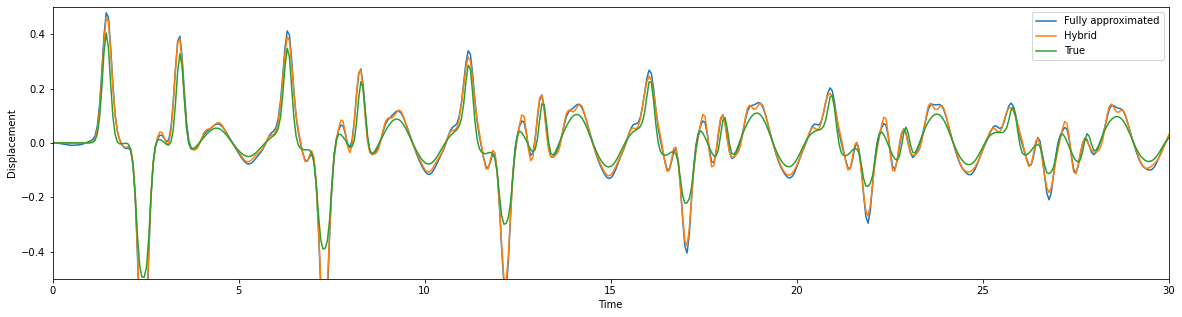

In [31]:
plt.figure(figsize=(20,5))
plot_seismogram(y_tilde_approx, 0.8)
plot_seismogram(y_tilde_hybrid, 0.8)
plot_seismogram(y_true, 0.8)
plt.xlim(0, 30)
plt.legend(['Fully approximated', 'Hybrid', 'True'])
plt.show()

### No Attenuation

Unfortunately not converging and blowing up after the 3rd iteration. Did no have the time to look into it in detail. Matrices are probably to ill-conditioned to be used diretly for generalized inverse.